In [206]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rich import print
import numpy as np
import warnings

In [207]:
warnings.filterwarnings("ignore", message="Workbook contains no default style, apply openpyxl's default")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [208]:
folder_path = 'TothSpreadsheets'

In [209]:
instruments_count = {}
for file_name in os.listdir(folder_path):
    if file_name.startswith('Toth') and file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        labels = df.iloc[3:, 0].tolist()
        for label in labels:
            instruments_count[label] = instruments_count.get(label, 0) + 1
            if pd.isna(label):
                print(f'Empty label in {file_name}')

print(instruments_count)

{
    'Jegogan': 94,
    'Calung': 99,
    'Giying': 76,
    'Pemade': 178,
    'Kantilan': 146,
    'Penyacah': 37,
    'Reyong': 57,
    'Trompong': 62
}

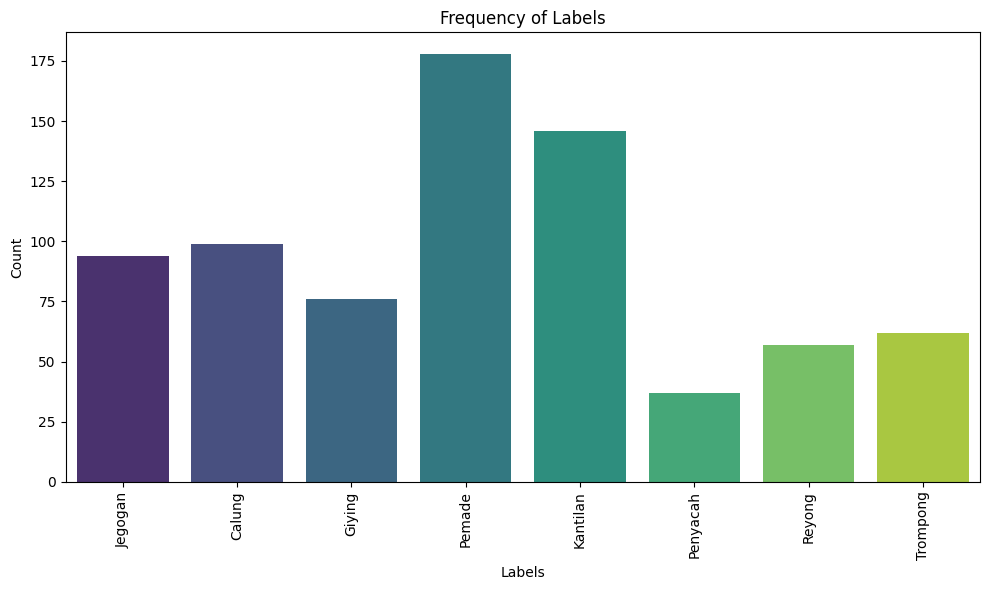

In [210]:
data = pd.DataFrame({'Labels': list(instruments_count.keys()), 'Count': list(instruments_count.values())})
plt.figure(figsize=(10, 6))
sns.barplot(x='Labels', y='Count', data=data, palette='viridis')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Frequency of Labels')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [211]:
classification = {}
for file_name in os.listdir(folder_path):
    if file_name.startswith('Toth') and file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        for _, row in df.iloc[3:].iterrows():
            label, value = row[0:2]
            if label not in classification:
                classification[label] = {'pengisep': 0, 'pengumbang': 0}
            if value == '+':
                classification[label]['pengisep'] += 1
            elif value == '-':
                classification[label]['pengumbang'] += 1

print(classification)

{
    'Jegogan': {'pengisep': 46, 'pengumbang': 48},
    'Calung': {'pengisep': 49, 'pengumbang': 50},
    'Giying': {'pengisep': 38, 'pengumbang': 38},
    'Pemade': {'pengisep': 88, 'pengumbang': 90},
    'Kantilan': {'pengisep': 72, 'pengumbang': 74},
    'Penyacah': {'pengisep': 19, 'pengumbang': 18},
    'Reyong': {'pengisep': 18, 'pengumbang': 39},
    'Trompong': {'pengisep': 34, 'pengumbang': 28}
}

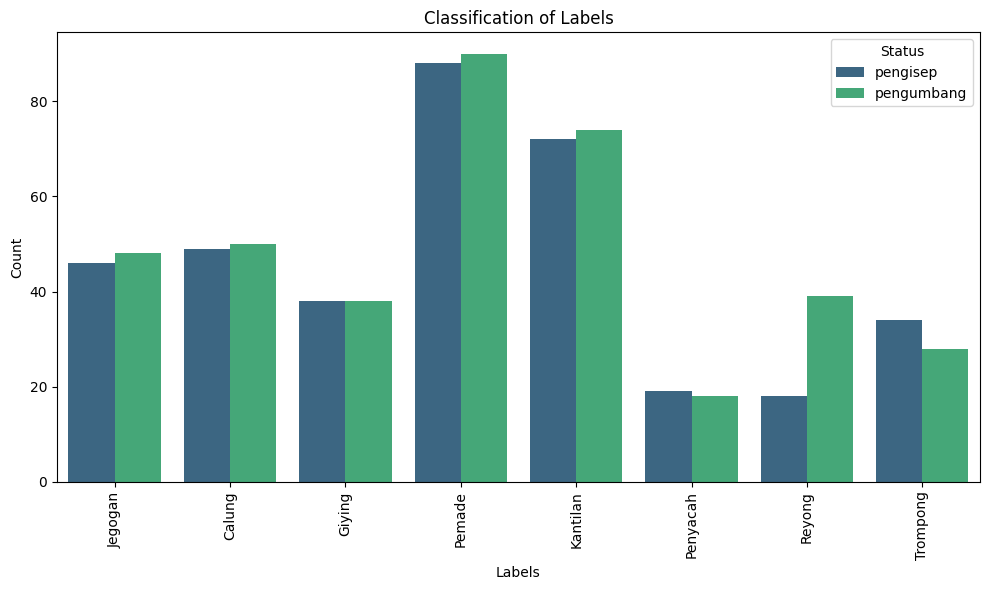

In [212]:
data = pd.DataFrame([(label, status, count) for label, status_dict in classification.items() for status, count in status_dict.items()], columns=['Labels', 'Status', 'Count'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Labels', y='Count', hue='Status', data=data, palette='viridis')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Classification of Labels')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [213]:
gamelan_blacklist = ["Kalapaksa", "Br Kawan Bangli"]
label_filter = ["Instrument", "Flavor", "ding3", "dong3", "deng3", "dung3", "dang3", "ding4"]
gamelan_data = {}
dataset_labels = ["Region", "Gamelan", "Flavor", "ding3", "dong3", "deng3", "dung3", "dang3", "ding4"]
dataset_df = pd.DataFrame([], columns=dataset_labels)

for file_name in os.listdir(folder_path):
    if file_name.startswith("Toth") and file_name.endswith(".xlsx"):
        file_path = os.path.join(folder_path, file_name)
        
        # Read Excel file
        df = pd.read_excel(file_path, header=None)
        
        # Get gamelan name and regency name
        gamelan_name = df.iloc[0, 0]
        regency_name = df.iloc[1, 0]

        # Skip blacklisted gamelan
        if gamelan_name in gamelan_blacklist: continue

        # Organize labels
        labels = df.iloc[3, :].tolist()
        labels[0], labels[1] = "Instrument", "Flavor"
        oct_labels = []
        count = 0
        for label in labels:
            if label in ["Instrument", "Flavor"]:
                oct_labels.append(label)
                continue
            if label == "ding": count += 1
            oct_labels.append(f"{label}{count}")

        # Get the pemade data
        pemade_pengumbang = pd.Series([np.nan] * len(oct_labels))
        pemade_pengisep = pd.Series([np.nan] * len(oct_labels))
        pemade_df = pd.DataFrame([], columns=oct_labels)
        for index, row in df.iterrows():
            if index >= 4:
                instrument = row[0]
                if instrument == "Pemade":
                    value_list = row.to_list()
                    count = sum(1 for value in value_list if pd.notna(value)) - 2
                    if count == 1: continue # There is one pemade with only one note :/
                    # print(value_list)
                    pemade_df = pd.concat([pemade_df, pd.DataFrame([value_list], columns=oct_labels)], ignore_index=True)
        
        # Filter the pemade data
        pemade_df = pemade_df[label_filter]
        pemade_df.dropna(inplace=True)

        # Split the pemade data
        pemade_pengisep_df = pemade_df[pemade_df["Flavor"] == "+"]
        pemade_pengumbang_df = pemade_df[pemade_df["Flavor"] == "-"]

        # # Compute means
        # pemade_mean = pemade_df.iloc[:, 2:9].mean()
        # pemade_pengumbang_mean = pemade_pengumbang_df.iloc[:, 2:9].mean()
        # pemade_pengisep_mean = pemade_pengisep_df.iloc[:, 2:9].mean()

        # Append to the dictionary
        if not regency_name in gamelan_data: gamelan_data[regency_name] = {}
        gamelan_data[regency_name][gamelan_name] = {
            "pemade": pemade_df,
            "pemade+": pemade_pengisep_df,
            "pemade-": pemade_pengumbang_df,
        }

for regency, gamelan_dict in gamelan_data.items():
    for gamelan, gamelan_data_2 in gamelan_dict.items():
        pemade_data = gamelan_data_2["pemade"]
        pemade_pengumbang_data = gamelan_data_2["pemade+"]
        pemade_pengisep_data = gamelan_data_2["pemade-"]
        for index, row in pemade_data.iterrows():
            dataset_df = pd.concat([dataset_df, pd.DataFrame([[regency, gamelan, row["Flavor"], *row[2:]]], columns=dataset_labels)], ignore_index=True)
        for index, row in pemade_pengumbang_data.iterrows():
            dataset_df = pd.concat([dataset_df, pd.DataFrame([[regency, gamelan, row["Flavor"], *row[2:]]], columns=dataset_labels)], ignore_index=True)
        for index, row in pemade_pengisep_data.iterrows():
            dataset_df = pd.concat([dataset_df, pd.DataFrame([[regency, gamelan, row["Flavor"], *row[2:]]], columns=dataset_labels)], ignore_index=True)

dataset_region_pengisep_df = dataset_df[dataset_df["Flavor"] == "+"]
dataset_region_pengisep_means = dataset_region_pengisep_df.drop(columns=["Gamelan", "Flavor"])
dataset_region_pengisep_means = dataset_region_pengisep_means.groupby("Region", as_index=False).mean()

dataset_region_pengumbang_df = dataset_df[dataset_df["Flavor"] == "-"]
dataset_region_pengumbang_means = dataset_region_pengumbang_df.drop(columns=["Gamelan", "Flavor"])
dataset_region_pengumbang_means = dataset_region_pengumbang_means.groupby("Region", as_index=False).mean()

dataset_region_df = dataset_df.copy()
dataset_region_means = dataset_region_df.drop(columns=["Gamelan", "Flavor"])
dataset_region_means = dataset_region_means.groupby("Region", as_index=False).mean()

In [214]:
dataset_df

,Region,Gamelan,Flavor,ding3,dong3,deng3,dung3,dang3,ding4
0,Gianyar,Sumampan,-,553.1,595.2,644.6,810.7,873.4,1115.2
1,Gianyar,Sumampan,-,554.4,597.9,647.2,813.5,880.0,1117.1
2,Gianyar,Sumampan,+,561.5,603.1,652.1,818.2,883.1,1124.9
3,Gianyar,Sumampan,+,561.5,603.1,652.1,818.2,883.1,1124.9
4,Gianyar,Sumampan,-,553.1,595.2,644.6,810.7,873.4,1115.2
...,...,...,...,...,...,...,...,...,...
317,Bangli,Blungbang Bangli,+,484.3,533.0,582.9,738.7,848.1,992.3
318,Bangli,Blungbang Bangli,+,482.9,532.4,585.0,732.8,848.6,993.5
319,Bangli,Blungbang Bangli,+,484.3,533.0,582.9,738.7,848.1,992.3
320,Bangli,Blungbang Bangli,-,479.0,531.5,574.9,726.4,807.9,986.1


In [215]:
dataset_region_means

,Region,ding3,dong3,deng3,dung3,dang3,ding4
0,Badung,546.815625,586.790625,652.893750,808.662500,866.509375,1101.512500
1,Bangli,588.712500,641.012500,705.975000,902.987500,981.575000,1212.162500
2,Buleleng,544.816129,585.712903,646.096774,814.619355,871.183871,1106.645161
3,Gianyar,545.788889,587.402778,648.211111,804.033333,865.136111,1101.719444
4,Karangasem,504.200000,540.722222,596.733333,740.355556,797.222222,1006.855556
5,Klungklung,488.204000,527.064000,577.928000,724.920000,783.740000,996.416000
6,Tabanan,518.860000,557.125000,616.630000,763.815000,821.745000,1041.060000


In [216]:
dataset_region_pengisep_means

,Region,ding3,dong3,deng3,dung3,dang3,ding4
0,Badung,550.475000,590.656250,656.906250,812.581250,869.950000,1105.225000
1,Bangli,592.450000,644.350000,710.900000,906.625000,994.475000,1215.575000
2,Buleleng,547.826667,589.173333,649.493333,818.600000,874.693333,1110.020000
3,Gianyar,548.950000,590.777778,651.927778,807.572222,868.511111,1104.777778
4,Karangasem,504.300000,540.400000,595.580000,736.360000,793.880000,1000.780000
5,Klungklung,491.558333,531.300000,581.725000,728.958333,786.883333,1001.008333
6,Tabanan,522.030000,561.240000,620.550000,767.250000,825.450000,1045.160000


In [217]:
dataset_region_pengumbang_means

,Region,ding3,dong3,deng3,dung3,dang3,ding4
0,Badung,543.156250,582.925000,648.881250,804.743750,863.068750,1097.800000
1,Bangli,584.975000,637.675000,701.050000,899.350000,968.675000,1208.750000
2,Buleleng,541.993750,582.468750,642.912500,810.887500,867.893750,1103.481250
3,Gianyar,542.627778,584.027778,644.494444,800.494444,861.761111,1098.661111
4,Karangasem,504.075000,541.125000,598.175000,745.350000,801.400000,1014.450000
5,Klungklung,485.107692,523.153846,574.423077,721.192308,780.838462,992.176923
6,Tabanan,515.690000,553.010000,612.710000,760.380000,818.040000,1036.960000
